In [15]:
%config Completer.use_jedi = False

# 1.Packages

In [16]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display

# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None) # 保证最大列数没有限制，能看到所有的列，不会被截断
pd.options.display.float_format = '{:.2f}'.format # 浮点数在DataFrame里的显示格式
warnings.filterwarnings('ignore') # 忽略

# 2. Import Data

In [18]:
train_data = pd.read_csv("input/train.csv")
test_data = pd.read_csv("input/test.csv")
stores_data = pd.read_csv("input/stores.csv")
# sort_values 排序的第一条件是store_nbr，第二条件才是date 
transactions_data = pd.read_csv("input/transactions.csv").sort_values(["store_nbr", "date"])

# Datetime
train_data["date"]= pd.to_datetime(train_data.date)
test_data["date"] = pd.to_datetime(test_data.date)
transactions_data["date"] = pd.to_datetime(transactions_data.date)

# DATA Type
train_data.onpromotion = train_data.onpromotion.astype("float16") # 因为促销有可能是分数
train_data.sales = train_data.sales.astype("float16") # 销售出的东西也可能是分数
stores_data.cluster = stores_data.cluster.astype("int8") # 商店所属的类别

train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00
1,1,2013-01-01,1,BABY CARE,0.00,0.00
2,2,2013-01-01,1,BEAUTY,0.00,0.00
3,3,2013-01-01,1,BEVERAGES,0.00,0.00
4,4,2013-01-01,1,BOOKS,0.00,0.00


# 3.Transaction

In [ ]:
transactions_data # 每个store在[time]期间的交易量

**reset_index**：相当于原本是一个导图的格式，转换成了表格的格式，好像是数据库的什么范式的转换？

In [ ]:
train_data.groupby(["date","store_nbr"]).sales.sum().reset_index().head() # 每天各个[store]的销售额

In [ ]:
temp = pd.merge(train_data.groupby(["date","store_nbr"]).sales.sum().reset_index(), transactions_data, how="left")
temp.head(100) # 得到的就是

至此，就得到了某一天，某个零售商的销售额和交易量。

什么是销售额？

sales：销售的金额，是钱

transactions：交易次数，包括“销售商品、退款等等”

In [ ]:
temp.corr("spearman").sales.transactions # 计算各列的spearman相关系数

In [ ]:
print("Spearman Correlation between Total Sales and Transactions: {:,.4f}".format(temp.corr("spearman").sales.transactions))

[spearman correlation](https://blog.csdn.net/chenxy_bwave/article/details/121427036?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522170202365616800192281395%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=170202365616800192281395&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-1-121427036-null-null.142^v96^pc_search_result_base1&utm_term=spearman%20correlation&spm=1018.2226.3001.4187)

## 什么是spearman系数？

和pearson correlation的区别：
* pearson: 
    * 两个随即变量之间线性关系强度
    * 计算此系数用的是数据本身
* spearson：两个随即变量之间的单调关系强度
    * 非参数版本：用不到数据本身，用的是数据样本排队位次
    * 不需要先验知识

## 什么时候要用spearman的相关系数？

在能够用pearman的时候，就用pearman，否则再参考spearman。主要有以下几种:

1. 非线性关系的数据
2. ordinal类型的数据，什么叫做ordinal的数据？

eg:

Education Levels:

High School Diploma
Associate's Degree
Bachelor's Degree
Master's Degree
Doctorate

Survey Responses:

Strongly Disagree
Disagree
Neutral
Agree
Strongly Agree
3. 有明显的异常值(outliers)

## 公式：

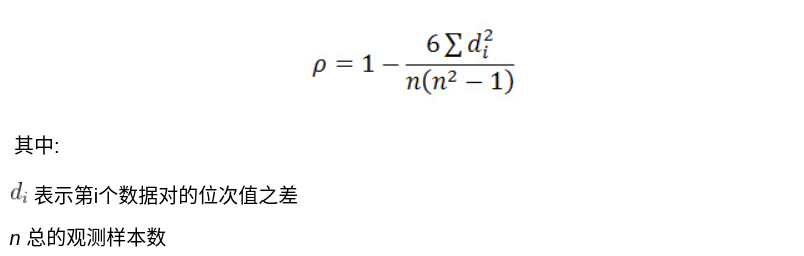
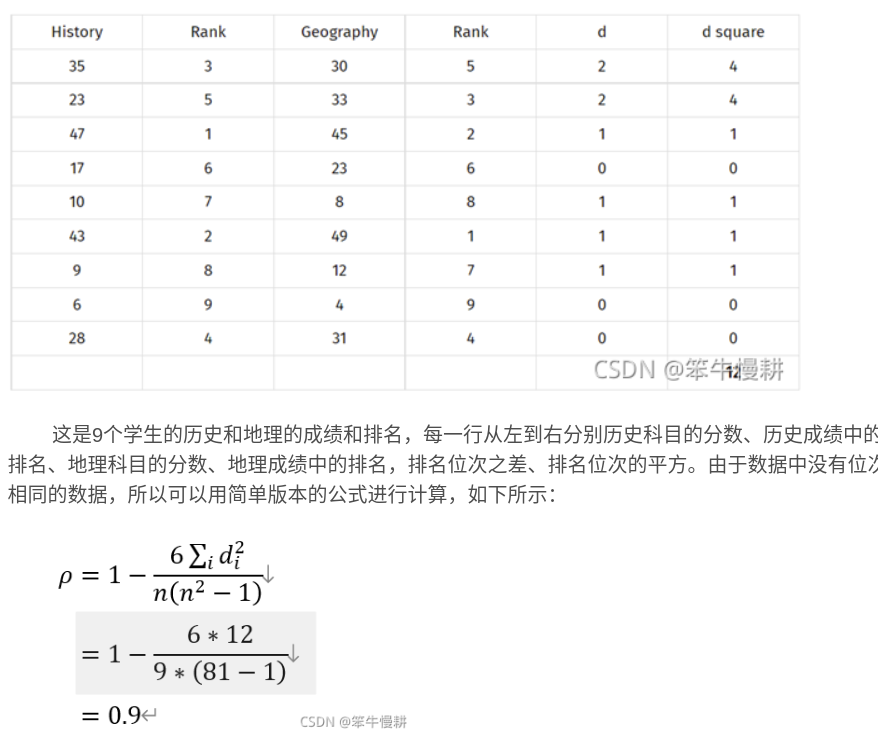

上述计算的是history和geography的spearman系数。实际上我们根本没有用到实际的history的数据，而是对列都排列个序，确定了每个值的rank，然后用这个rank得到的spearman的系数～

## 结论：
spearman得到的历史好的人，地理都会挺好。

**并且sales和transactions之间也有关系，sales销售额多，则transactions大概率也会多。**




In [ ]:
px.line(transactions_data.sort_values(["date","store_nbr"]), x='date', y='transactions', color='store_nbr', title='不同时期不同零售商的交易量')

可以看到从2013-2017年，大多时候的交易量都是stable的，除了Dec的时候有突然的增长。

In [ ]:
a = transactions_data.copy()
a["year"] = a.date.dt.year
a["month"] = a.date.dt.month
px.box(a, x="year", y="transactions", color="month",title="Transactions" )

In [ ]:
a = transactions_data.transactions.mean()
a

In [ ]:
a = transactions_data.set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year
px.line(a, x='date', y='transactions', color='year', title="Monthly Average Transactions")

transactions_date原本是有天然的索引1,2,... 

然后列名分别是: date, store, transactions

现在用set_index("date")就使得让索引变成了date，失去了自然索引

.set_index("date").resample("M")的作用：

将时间序列按照月份（M）重采样，然后计算每个月的平均值。

**什么是重采样？**

就是改变采样的粒度，本来是每天采点数据，现在是每月/每年采点数据~ 利于数据分析和观测~



In [ ]:
px.scatter(temp, x = "transactions", y = "sales", trendline = "ols", trendline_color_override = "red")

trendline：趋势线，可以接收以下取值：

* ols: least square 最小二乘法

* lowess: 使用局部加权三点  （非线性）

* exp: 指数函数曲线

* poly: 多项式曲线

In [ ]:
a = transactions_data.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.day_of_week + 1
a = a.groupby(["year","dayofweek"]).transactions.mean().reset_index()
px.line(a, x = "dayofweek", y = "transactions", color="year", title = "Average week transactions")

可以发现周六和周日的交易量相比周中的交易量要多很多。好了，分析好了sale和transactions的数据之后分析以下油价~

# 4. Oil Price

由于这个国家是oil-dependent的，所以油价会影响居民的消费能力。

In [ ]:
# Import
oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil.date)
# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
# Interpolate 插值一下  因为有些油价是不存在的

